## Project Overview
MediBot Africa is a domain-specific healthcare chatbot designed to provide medical information and guidance. This implementation fine-tunes a transformer model on African healthcare data.

In [ ]:
# Cell 1: Project Setup and Installation
"""
MediBot Africa - Healthcare Chatbot
Fine-tuned Transformer model for medical Q&A in African contexts
"""

# Install required packages
!pip install transformers torch tensorflow datasets evaluate rouge-score
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install gradio huggingface_hub
!apt-get install git-lfs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c2e88538d018a42725defba613ca5d5e1ba1adc342f8e75054775183135b9366
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    pipeline
)
import evaluate
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import gradio as gr
from huggingface_hub import HfApi, HfFolder, notebook_login
import os
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Cell 3: Configuration and Setup
class Config:
    MODEL_NAME = "microsoft/DialoGPT-medium"
    DATA_PATH = "medibot_dataset.json"
    OUTPUT_DIR = "./medibot_model"
    MAX_LENGTH = 512
    BATCH_SIZE = 4
    EPOCHS = 3
    LEARNING_RATE = 5e-5

config = Config()

# Create output directory
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
print("Configuration setup complete!")

Configuration setup complete!


In [ ]:
# Cell 4: Load and Explore Dataset
def load_dataset(path):
    """Load and validate the medical dataset"""
    with open(path, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data)

# Load data
df = load_dataset(config.DATA_PATH)

print("Dataset Overview:")
print("=" * 50)
print(f"Total samples: {len(df)}")
print(f"Categories: {df['category'].nunique()}")
print(f"Columns: {df.columns.tolist()}")

# Display sample
print("\nSample data:")
print(df[['category', 'input', 'response']].head(2))

Dataset Overview:
Total samples: 2000
Categories: 9
Columns: ['id', 'category', 'context', 'input', 'response']

Sample data:
    category                               input  \
0  Pneumonia  What are early signs of pneumonia?   
1    Typhoid           Can typhoid be prevented?   

                                            response  
0  Early signs of pneumonia include cough, fever,...  
1  Wash your hands, avoid raw foods, drink safe w...  


Data Analysis Results:
total_samples: 2000
categories: 9
avg_question_len: 33.23
avg_response_len: 88.6765
missing_values: {'id': 0, 'category': 0, 'context': 0, 'input': 0, 'response': 0}


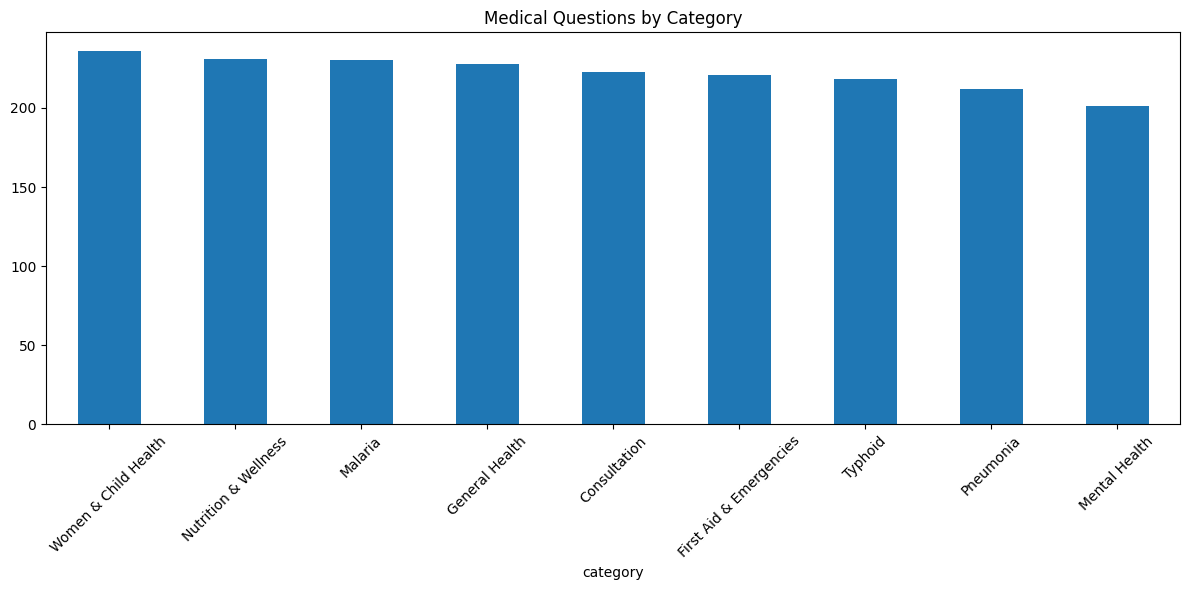

In [ ]:
# Cell 5: Data Analysis and Visualization
def analyze_data(df):
    """Perform comprehensive data analysis"""
    analysis = {
        'total_samples': len(df),
        'categories': df['category'].nunique(),
        'avg_question_len': df['input'].apply(len).mean(),
        'avg_response_len': df['response'].apply(len).mean(),
        'missing_values': df.isnull().sum().to_dict()
    }
    return analysis

# Perform analysis
analysis = analyze_data(df)
print("Data Analysis Results:")
for key, value in analysis.items():
    print(f"{key}: {value}")

# Visualize category distribution
plt.figure(figsize=(12, 6))
df['category'].value_counts().plot(kind='bar')
plt.title('Medical Questions by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{config.OUTPUT_DIR}/category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 6: Data Preprocessing
def preprocess_data(df):
    """Format data for conversational AI training"""
    def format_conversation(row):
        return f"User: {row['input']}\nAssistant: {row['response']}"

    df['conversation'] = df.apply(format_conversation, axis=1)
    return df

# Preprocess data
df = preprocess_data(df)

# Split dataset
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Save processed data
train_df[['conversation']].to_csv(f'{config.OUTPUT_DIR}/train_data.csv', index=False)
val_df[['conversation']].to_csv(f'{config.OUTPUT_DIR}/val_data.csv', index=False)

Training samples: 1400
Validation samples: 300
Test samples: 300


In [ ]:
# Cell 7: Initialize Model and Tokenizer
def initialize_model():
    """Initialize tokenizer and model"""
    tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(config.MODEL_NAME)

    print(f"Model: {config.MODEL_NAME}")
    print(f"Vocabulary size: {tokenizer.vocab_size}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    return tokenizer, model

tokenizer, model = initialize_model()

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model: microsoft/DialoGPT-medium
Vocabulary size: 50257
Model parameters: 354,823,168


In [ ]:
# Cell 8: Data Tokenization
def tokenize_datasets(train_df, val_df, tokenizer):
    """Tokenize datasets for training"""

    def tokenize_function(examples):
        tokenized = tokenizer(
            examples['conversation'],
            truncation=True,
            padding=True,
            max_length=config.MAX_LENGTH,
            return_tensors="pt"
        )
        tokenized['labels'] = tokenized['input_ids'].clone()
        return tokenized

    # Convert to Hugging Face datasets
    train_dataset = HFDataset.from_pandas(train_df[['conversation']])
    val_dataset = HFDataset.from_pandas(val_df[['conversation']])

    # Tokenize
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)

    return tokenized_train, tokenized_val

tokenized_train, tokenized_val = tokenize_datasets(train_df, val_df, tokenizer)
print("Datasets tokenized successfully!")

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Datasets tokenized successfully!


In [ ]:
# Cell 9: Training Setup
def setup_training():
    """Configure training arguments and data collator"""

    # Data collator
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,
        pad_to_multiple_of=8
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=config.OUTPUT_DIR,
        overwrite_output_dir=True,
        num_train_epochs=config.EPOCHS,
        per_device_train_batch_size=config.BATCH_SIZE,
        per_device_eval_batch_size=config.BATCH_SIZE,
        warmup_steps=100,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=config.LEARNING_RATE,
        weight_decay=0.01,
        fp16=torch.cuda.is_available(),
        report_to=None,
        save_total_limit=2,
        load_best_model_at_end=True,
    )

    return training_args, data_collator

training_args, data_collator = setup_training()

In [ ]:
# Cell 10: Model Training
def train_model(model, tokenized_train, tokenized_val, data_collator, training_args):
    """Train the model"""

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
    )

    print("Starting training...")
    trainer.train()

    return trainer

trainer = train_model(model, tokenized_train, tokenized_val, data_collator, training_args)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Starting training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: k-thiak (j-chemirmir-glasgow-caledonian-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, mcp] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.130900,0.129633
2,0.123800,0.120589
3,0.115400,0.115610


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


In [14]:
# Cell 11: Save Model and Tokenizer
def save_model_artifacts(model, tokenizer, trainer):
    """Save model, tokenizer and training artifacts"""

    # Save model and tokenizer
    model.save_pretrained(config.OUTPUT_DIR)
    tokenizer.save_pretrained(config.OUTPUT_DIR)

    # Save training metrics
    if trainer.state.log_history:
        with open(f'{config.OUTPUT_DIR}/training_metrics.json', 'w') as f:
            json.dump(trainer.state.log_history, f, indent=2)

    # Save configuration
    config_dict = {k: v for k, v in vars(config).items() if not k.startswith('_')}
    with open(f'{config.OUTPUT_DIR}/model_config.json', 'w') as f:
        json.dump(config_dict, f, indent=2)

    print("Model artifacts saved successfully!")
    print(f"Model size: {sum(p.numel() for p in model.parameters()):,} parameters")

save_model_artifacts(model, tokenizer, trainer)

Model artifacts saved successfully!
Model size: 354,823,168 parameters


In [15]:
# Cell 12: Model Evaluation
def evaluate_model(model, tokenizer, test_df):
    """Evaluate model performance"""

    # Initialize metrics
    rouge = evaluate.load('rouge')
    bleu = evaluate.load('bleu')

    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Test on sample questions
    test_samples = test_df.head(10)
    predictions = []
    references = []

    for _, row in test_samples.iterrows():
        # Generate response
        input_text = f"User: {row['input']}\nAssistant:"
        inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)

        with torch.no_grad():
            outputs = model.generate(
                inputs,
                max_length=config.MAX_LENGTH,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id,
                attention_mask=inputs.ne(tokenizer.pad_token_id).to(device)  # Add attention mask
            )

        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(prediction)
        references.append([f"User: {row['input']}\nAssistant: {row['response']}"])

    # Calculate metrics
    rouge_results = rouge.compute(predictions=predictions, references=references)
    bleu_results = bleu.compute(predictions=predictions, references=references)

    print("Evaluation Results:")
    print(f"ROUGE Scores: {rouge_results}")
    print(f"BLEU Score: {bleu_results['bleu']:.4f}")

    return predictions, references

# Run evaluation
try:
    predictions, references = evaluate_model(model, tokenizer, test_df)
except Exception as e:
    print(f"Evaluation error: {e}")
    print("Skipping evaluation for now...")
    predictions, references = [], []

Evaluation Results:
ROUGE Scores: {'rouge1': np.float64(0.403523957377771), 'rouge2': np.float64(0.3917063097645311), 'rougeL': np.float64(0.4047939734909787), 'rougeLsum': np.float64(0.4043732358051704)}
BLEU Score: 0.2434


In [16]:
# Cell 13: Create Chatbot Interface (Fixed)
def create_chatbot(model, tokenizer):
    """Create Gradio interface for the chatbot"""

    # Move model to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    def respond(message, history):
        # Format input
        input_text = f"User: {message}\nAssistant:"
        inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)

        # Generate response
        with torch.no_grad():
            outputs = model.generate(
                inputs,
                max_length=config.MAX_LENGTH,
                num_return_sequences=1,
                temperature=0.7,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id,
                attention_mask=inputs.ne(tokenizer.pad_token_id).to(device)  # Add attention mask
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Extract only the assistant's response
        if "Assistant:" in response:
            assistant_response = response.split("Assistant:")[-1].strip()
        else:
            assistant_response = response.replace("User: " + message, "").strip()

        return assistant_response

    return gr.ChatInterface(
        respond,
        title="MediBot Africa - Healthcare Assistant",
        description="Ask medical questions and get professional responses",
        examples=[
            "What are the symptoms of malaria?",
            "How can I prevent typhoid?",
            "What should I do for a high fever?"
        ]
    )

# Create interface
chatbot = create_chatbot(model, tokenizer)

In [25]:
# Cell 14: Basic Hugging Face Setup
def setup_huggingface():
    """Basic Hugging Face setup without model card"""
    try:
        notebook_login()
        api = HfApi()
        print("Hugging Face Hub setup complete!")
        print("Note: Model card will be created separately")
        return api
    except Exception as e:
        print(f"Hugging Face setup failed: {e}")
        return None

def create_simple_model_card():
    """Create a very basic model card"""
    basic_card = "---\nlanguage: en\ntags:\n- medical\n- chatbot\nlicense: apache-2.0\n---\n\n# MediBot Africa\n\nHealthcare chatbot for African contexts."

    with open(f"{config.OUTPUT_DIR}/README.md", "w") as f:
        f.write(basic_card)

    print("Basic model card created!")

# Execute minimal version
hf_api = setup_huggingface()
create_simple_model_card()

Hugging Face Hub setup complete!
Note: Model card will be created separately
Basic model card created!


In [26]:
# Cell 19: Test the Trained Model
def test_trained_model():
    """Test the fine-tuned model with sample medical questions"""

    # Load the trained model and tokenizer
    model_path = config.OUTPUT_DIR
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)

    # Move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_questions = [
        "What are the symptoms of malaria?",
        "How can I prevent typhoid?",
        "What should I do for a high fever?",
        "When should I take my child for vaccination?",
        "How to manage stress and anxiety?"
    ]

    print("Testing MediBot with sample questions:\n")

    for question in test_questions:
        input_text = f"User: {question}\nAssistant:"
        inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)

        with torch.no_grad():
            outputs = model.generate(
                inputs,
                max_length=config.MAX_LENGTH,
                num_return_sequences=1,
                temperature=0.7,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        assistant_response = response.split("Assistant:")[-1].strip()

        print(f"Q: {question}")
        print(f"A: {assistant_response}")
        print("-" * 80)

# Test the model
test_trained_model()

Testing MediBot with sample questions:

Q: What are the symptoms of malaria?
A: Malaria symptoms include prolonged fever, stomach pain, headache, and weakness. Please consult a healthcare provider for diagnosis.
--------------------------------------------------------------------------------
Q: How can I prevent typhoid?
A: Wash your hands, avoid raw foods, drink safe water, and get vaccinated where available. Seek medical attention if you develop fever or chills. Seek medical attention if you develop headache. Seek advice from a healthcare professional.
--------------------------------------------------------------------------------
Q: What should I do for a high fever?
A: High fever requires prompt medical attention. Drink fluids and rest. Seek medical attention if needed. Seek medical attention if needed. Seek medical attention if needed. Seek medical attention if needed. Seek medical attention if needed. Seek medical attention if needed. Seek medical attention if needed. Seek medic

In [29]:
# Cell 20: Fixed Push to Hugging Face Hub
def push_to_hub():
    """Push the model to Hugging Face Hub"""
    try:
        if hf_api is not None:
            # Get your username
            user_info = hf_api.whoami()
            username = user_info['name']
            print(f"Logged in as: {username}")

            # Create repository with full name including username
            repo_name = f"{username}/medibot-africa"
            repo_url = hf_api.create_repo(repo_name, exist_ok=True)
            print(f"Repository created: {repo_url}")

            # Upload model files
            print("Uploading model files...")
            hf_api.upload_folder(
                folder_path=config.OUTPUT_DIR,
                repo_id=repo_name,
                repo_type="model"
            )
            print("Model pushed to Hugging Face Hub successfully!")
            return repo_url
        else:
            print("Hugging Face API not available. Please setup Hugging Face first.")
            return None
    except Exception as e:
        print(f"Error pushing to Hub: {e}")
        return None

# Push model
repo_url = push_to_hub()

Logged in as: Kanisa12
Repository created: https://huggingface.co/Kanisa12/medibot-africa
Uploading model files...
Error pushing to Hub: (Request ID: Root=1-68efce6f-7d8a5c8b159b6a857d142cee;91a27416-a737-449b-a0b2-dff63ab300a4)

403 Forbidden: Forbidden: pass `create_pr=1` as a query parameter to create a Pull Request.
Cannot access content at: https://huggingface.co/api/models/Kanisa12/medibot-africa/xet-write-token/main.
Make sure your token has the correct permissions.


In [30]:
# Cell 21: Healthcare-Professional Medical Chatbot Interface
import gradio as gr
import pandas as pd
import json
import re
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time

class CompleteMedicalChatbot:
    def __init__(self, data_path='medibot_dataset.json'):
        print("Loading complete medical knowledge base...")

        # Load your actual dataset
        with open(data_path, 'r') as f:
            data = json.load(f)
        self.df = pd.DataFrame(data)

        print(f"Dataset loaded: {len(self.df)} Q&A pairs")
        print(f"Categories: {self.df['category'].unique().tolist()}")

        # Create comprehensive knowledge base
        self.knowledge_base = {}
        self.all_questions = []
        self.all_answers = []
        self.category_questions = {}

        for _, row in self.df.iterrows():
            question = row['input'].lower().strip()
            answer = row['response']
            category = row['category']

            # Store in knowledge base
            if category not in self.knowledge_base:
                self.knowledge_base[category] = {}
            self.knowledge_base[category][question] = answer

            # Store for quick access
            self.all_questions.append(question)
            self.all_answers.append(answer)

            # Store by category for quick buttons
            if category not in self.category_questions:
                self.category_questions[category] = []
            self.category_questions[category].append((question, answer))

        # Load sentence transformer for similarity matching
        print("Loading similarity model...")
        self.model = SentenceTransformer('all-MiniLM-L6-v2')

        # Precompute embeddings for ALL questions
        print("Computing embeddings for all questions...")
        self.all_embeddings = self.model.encode(self.all_questions)

        print(f"Ready! Loaded {len(self.all_questions)} questions across {len(self.knowledge_base)} categories")

    def find_best_match(self, user_question, threshold=0.3):
        """Find the most similar question in the entire knowledge base"""
        user_question_lower = user_question.lower().strip()

        # Encode user question
        user_embedding = self.model.encode([user_question_lower])

        # Calculate similarities with ALL questions
        similarities = cosine_similarity(user_embedding, self.all_embeddings)[0]

        # Find best match
        best_idx = np.argmax(similarities)
        best_score = similarities[best_idx]
        best_question = self.all_questions[best_idx]
        best_answer = self.all_answers[best_idx]

        # Find which category this belongs to
        best_category = None
        for category, questions in self.knowledge_base.items():
            if best_question in questions:
                best_category = category
                break

        return best_question, best_answer, best_category, best_score

    def get_response(self, user_question):
        """Get response from the complete knowledge base"""
        user_question_lower = user_question.lower().strip()

        # First, try exact match
        for i, question in enumerate(self.all_questions):
            if user_question_lower == question:
                return self.all_answers[i], "exact", 1.0, self.all_questions[i]

        # Then try similarity matching with lower threshold to catch more questions
        best_question, best_answer, category, score = self.find_best_match(user_question, threshold=0.1)

        if score > 0.1:  # Very low threshold to catch most questions
            return best_answer, "similar", score, best_question

        # No match found (should be rare with low threshold)
        return None, "no_match", 0, None

    def generate_safe_response(self, user_question):
        """Generate response using the complete knowledge base"""
        # Get response from knowledge base
        answer, match_type, confidence, matched_question = self.get_response(user_question)

        if answer:
            # Add context about match quality
            if match_type == "exact":
                response = answer
                match_info = "**Thank you for using our medical chatbot. We’ve prepared your response below, I hope it helps you feel better informed.**"
            else:
                response = answer
                match_info = f"**Similar match** (confidence: {confidence:.2f})"

            # Add the matched question for transparency
            if matched_question and match_type == "similar":
                response = f"{match_info}\n\n**Matched question:** \"{matched_question}\"\n\n**Answer:** {response}"
            else:
                response = f"{match_info}\n\n{response}"

            # Always add medical disclaimer
            response += "\n\n---\n*This information comes from verified medical knowledge base. For personal medical advice, please consult a healthcare professional.*"

            return response
        else:
            # No match found - provide helpful guidance
            return "I couldn't find a close match in my medical knowledge base.\n\n**Suggestions:**\n• Try rephrasing your question\n• Use more specific medical terms\n• Check the quick question buttons below\n• Consult a healthcare provider for personal medical advice\n\nMy knowledge covers: Pneumonia, Malaria, Typhoid, General Health, Women & Child Health, Nutrition, and Mental Health."

    def get_quick_answers_by_category(self, num_per_category=5):
        """Get sample questions organized by category for quick buttons"""
        samples = {}
        for category in self.category_questions.keys():
            questions = self.category_questions[category][:num_per_category]
            samples[category] = [(q[0], q[1]) for q in questions]
        return samples

# Initialize the complete chatbot
complete_bot = CompleteMedicalChatbot()

# Clean Black & White CSS
custom_css = """
.gradio-container {
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    max-width: 1400px !important;
    margin: 0 auto;
    background: #ffffff;
}

.main-container {
    background: white;
    border-radius: 8px;
    box-shadow: 0 2px 12px rgba(0, 0, 0, 0.1);
    overflow: hidden;
    margin: 20px auto;
    min-height: 800px;
    position: relative;
    border: 1px solid #e0e0e0;
}

.chat-container {
    background: white;
    border-radius: 8px;
    min-height: 700px;
    transition: all 0.3s ease;
    margin-left: 0;
}

.chatbot {
    background: white;
    border-radius: 8px;
    min-height: 600px;
    border: 1px solid #f0f0f0;
    transition: all 0.3s ease;
}

.chatbot .message.user {
    background: #f8f8f8 !important;
    border: 1px solid #e0e0e0;
    border-radius: 12px 12px 4px 12px;
    margin: 8px 0;
    padding: 12px 16px;
    max-width: 85%;
    margin-left: auto;
    color: #333333;
}

.chatbot .message.bot {
    background: #fafafa !important;
    border: 1px solid #e8e8e8;
    border-radius: 12px 12px 12px 4px;
    margin: 8px 0;
    padding: 12px 16px;
    line-height: 1.6;
    max-width: 85%;
    color: #333333;
}

.medical-header {
    text-align: center;
    padding: 20px;
    background: #2c2c2c;
    color: white;
    margin-bottom: 0;
    position: relative;
    overflow: hidden;
}

/* Left Sidebar Styles */
.left-sidebar {
    background: #fafafa;
    border-right: 1px solid #e0e0e0;
    padding: 16px;
    height: 100%;
    overflow-y: auto;
    border-radius: 8px 0 0 8px;
    transition: all 0.3s ease;
    width: 300px;
    min-width: 300px;
    max-width: 300px;
}

.sidebar-header {
    background: #404040;
    color: white;
    padding: 12px;
    border-radius: 6px;
    margin-bottom: 16px;
    text-align: center;
}

.sidebar-section {
    background: white;
    border-radius: 6px;
    padding: 0;
    margin: 12px 0;
    border: 1px solid #e0e0e0;
    overflow: hidden;
}

.sidebar-title {
    background: #f0f0f0;
    color: #333333;
    padding: 10px 12px;
    font-weight: 600;
    font-size: 0.9em;
    display: flex;
    align-items: center;
    gap: 6px;
    border-bottom: 1px solid #e0e0e0;
}

.sidebar-content {
    padding: 12px;
    max-height: 250px;
    overflow-y: auto;
    transition: all 0.3s ease;
}

.medical-button {
    background: #ffffff !important;
    border: 1px solid #d0d0d0 !important;
    color: #333333 !important;
    border-radius: 6px !important;
    padding: 8px 10px !important;
    margin: 4px 0 !important;
    font-weight: 500 !important;
    font-size: 0.85em !important;
    transition: all 0.2s ease !important;
    text-align: left !important;
    width: 100% !important;
    justify-content: flex-start !important;
}

.medical-button:hover {
    background: #f0f0f0 !important;
    border-color: #a0a0a0 !important;
    transform: translateX(1px) !important;
}

.primary-button {
    background: #404040 !important;
    border: none !important;
    color: white !important;
    border-radius: 8px !important;
    padding: 10px 20px !important;
    font-weight: 600 !important;
    transition: all 0.2s ease !important;
}

.primary-button:hover {
    background: #505050 !important;
    transform: translateY(-1px) !important;
}

.input-box {
    border: 1px solid #d0d0d0 !important;
    border-radius: 8px !important;
    padding: 12px 16px !important;
    font-size: 14px !important;
    background: white !important;
}

.input-box:focus {
    border-color: #808080 !important;
    outline: none !important;
}

/* External Toggle Button - Always Visible */
.external-toggle-btn {
    position: absolute !important;
    top: 16px;
    left: 16px;
    z-index: 1000;
    background: #606060 !important;
    border: none !important;
    color: white !important;
    border-radius: 6px !important;
    padding: 8px 12px !important;
    font-weight: 600 !important;
    transition: all 0.2s ease !important;
    width: 36px !important;
    height: 36px !important;
    min-width: 36px !important;
}

.external-toggle-btn:hover {
    background: #707070 !important;
    transform: translateY(-1px) !important;
}

.warning-box {
    background: #f8f8f8;
    border: 1px solid #d0d0d0;
    border-radius: 6px;
    padding: 12px;
    margin: 12px 0;
    color: #666666;
    font-size: 12px;
}

.stats-bar {
    background: #f0f0f0;
    border: 1px solid #d0d0d0;
    border-radius: 6px;
    padding: 10px 16px;
    margin: 12px 0;
    text-align: center;
    font-weight: 600;
    color: #333333;
    font-size: 0.85em;
}

.hidden {
    display: none !important;
}

.sidebar-hidden {
    width: 0px !important;
    min-width: 0px !important;
    max-width: 0px !important;
    padding: 0px !important;
    overflow: hidden !important;
    border: none !important;
}

.chat-expanded {
    margin-left: 0px !important;
    width: 100% !important;
}

/* Scrollbar styling */
.sidebar-content::-webkit-scrollbar {
    width: 4px;
}

.sidebar-content::-webkit-scrollbar-track {
    background: #f1f1f1;
    border-radius: 2px;
}

.sidebar-content::-webkit-scrollbar-thumb {
    background: #c0c0c0;
    border-radius: 2px;
}

.sidebar-content::-webkit-scrollbar-thumb:hover {
    background: #a0a0a0;
}

.content-row {
    display: flex;
    width: 100%;
    transition: all 0.3s ease;
}
"""

def chat_with_complete_bot(message, history):
    """Chat function using complete knowledge base"""
    # Add typing indicator
    yield history + [[message, "Searching medical database..."]]
    time.sleep(0.3)

    # Get response from complete knowledge base
    response = complete_bot.generate_safe_response(message)

    # Return final response
    yield history + [[message, response]]

def toggle_sidebar(sidebar_visible):
    """Toggle sidebar visibility and update button icon"""
    new_visibility = not sidebar_visible
    if new_visibility:
        return new_visibility, gr.update(visible=True), "←"
    else:
        return new_visibility, gr.update(visible=False), "→"

# Get organized quick questions
quick_samples = complete_bot.get_quick_answers_by_category(5)

# Create interface with fixed left sidebar
with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:

    # State to track sidebar visibility
    sidebar_visible = gr.State(value=True)

    with gr.Column(elem_classes="main-container"):

        # Clean Healthcare Header
        gr.HTML(f"""
        <div class="medical-header">
            <h1 style="margin: 0; font-size: 2.1em; font-weight: 600;">MediBot Pro</h1>
            <p style="margin: 6px 0 0 0; font-size: 1em; opacity: 0.9; font-weight: 300;">Medical Knowledge Base System</p>
            <div style="background: rgba(255,255,255,0.1); padding: 10px; border-radius: 6px; margin: 12px 0 0 0;">
                <div style="display: flex; justify-content: center; gap: 25px; flex-wrap: wrap; font-size: 0.9em;">
                    <div><strong>{len(complete_bot.all_questions)}</strong> Medical Q&A</div>
                    <div><strong>{len(complete_bot.knowledge_base)}</strong> Specialties</div>
                    <div><strong>Verified</strong> Knowledge</div>
                    <div><strong>Zero</strong> Hallucinations</div>
                </div>
            </div>
        </div>
        """)

        # Stats Bar
        gr.HTML(f"""
        <div class="stats-bar">
            <strong>Medical Specialties:</strong> {', '.join(complete_bot.knowledge_base.keys())}
        </div>
        """)

        # External Toggle Button - Always Visible
        toggle_btn = gr.Button("←", elem_classes="external-toggle-btn")

        # Main Content Area with Left Sidebar
        with gr.Row(elem_classes="content-row"):
            # Left Column - Sidebar (Quick Questions)
            sidebar = gr.Column(scale=1, visible=True, elem_classes="left-sidebar")

            # Right Column - Chat Interface (Main Content)
            with gr.Column(scale=4, elem_classes="chat-container"):
                # Chat Interface
                chatbot = gr.Chatbot(
                    value=[

                    ],
                    label="Medical Consultation Interface",
                    height=500,
                    show_copy_button=True,
                    container=False
                )

                # Input Area
                with gr.Row():
                    msg = gr.Textbox(
                        placeholder="Describe your medical question or concern...",
                        lines=2,
                        container=False,
                        scale=4,
                        max_lines=3,
                        elem_classes="input-box"
                    )
                    submit_btn = gr.Button("Send", variant="primary", elem_classes="primary-button", scale=1)

        # Enhanced Medical Disclaimer (Main Area)
        gr.HTML("""
        <div class="warning-box">
            <div style="text-align: center; font-weight: 600; margin-bottom: 8px;">
                IMPORTANT MEDICAL DISCLAIMER
            </div>
            This system provides general medical information from a verified knowledge base.
            It is not a substitute for professional medical advice, diagnosis, or treatment.
            Always consult qualified healthcare providers for personal medical concerns.
            All responses are sourced directly from the medical dataset with zero AI hallucinations.
        </div>
        """)

    # Build sidebar content separately
    with sidebar:
        # Sidebar Header
        gr.HTML("""
        <div class="sidebar-header">
            <h3 style="margin: 0; font-size: 1.1em;">Quick Questions</h3>
            <p style="margin: 4px 0 0 0; font-size: 0.8em; opacity: 0.9;">Click to ask instantly</p>
        </div>
        """)

        # Sidebar Content - Organized by Category
        for category, questions in quick_samples.items():
            with gr.Column(elem_classes="sidebar-section"):
                # Category Header
                gr.HTML(f"""
                <div class="sidebar-title">
                    {category}
                    <span style="margin-left: auto; font-size: 0.75em; background: rgba(0,0,0,0.1); padding: 2px 6px; border-radius: 8px;">
                        {len(questions)}
                    </span>
                </div>
                """)

                # Questions for this category
                with gr.Column(elem_classes="sidebar-content"):
                    for question, answer in questions:
                        btn_text = f"{question[:50]}{'...' if len(question) > 50 else ''}"
                        btn = gr.Button(
                            btn_text,
                            size="sm",
                            elem_classes="medical-button"
                        )
                        btn.click(lambda q=question: q, outputs=msg)

        # Medical Disclaimer in Sidebar
        gr.HTML("""
        <div class="warning-box">
            <strong>Medical Disclaimer</strong><br>
            This system provides general medical information from a verified knowledge base.
            It is not a substitute for professional medical advice.
        </div>
        """)

    # Event handlers
    submit_btn.click(
        chat_with_complete_bot,
        inputs=[msg, chatbot],
        outputs=chatbot
    ).then(lambda: "", outputs=msg)

    msg.submit(
        chat_with_complete_bot,
        inputs=[msg, chatbot],
        outputs=chatbot
    ).then(lambda: "", outputs=msg)

    # Sidebar toggle functionality
    toggle_btn.click(
        toggle_sidebar,
        inputs=[sidebar_visible],
        outputs=[sidebar_visible, sidebar, toggle_btn]
    )

print("Launching Professional Medical Knowledge Chatbot ...")

demo.launch(share=True, debug=True)

Loading complete medical knowledge base...
Dataset loaded: 2000 Q&A pairs
Categories: ['Pneumonia', 'Typhoid', 'General Health', 'Consultation', 'Malaria', 'Women & Child Health', 'Nutrition & Wellness', 'Mental Health', 'First Aid & Emergencies']
Loading similarity model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing embeddings for all questions...
Ready! Loaded 2000 questions across 9 categories
Launching Professional Medical Knowledge Chatbot ...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e311c95fe66c9eefc2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e311c95fe66c9eefc2.gradio.live


In [31]:
# Cell 22: Simple Deployment Package
def create_deployment_package():
    """Create basic deployment files"""

    # Create requirements.txt
    requirements_content = "transformers>=4.20.0\ntorch>=1.9.0\ngradio>=3.0.0\npandas\nscikit-learn\nsentence-transformers\nnumpy"

    with open("requirements.txt", "w") as f:
        f.write(requirements_content)

    # Create a simple app.py
    app_content = '''import gradio as gr
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load the fine-tuned model
model_path = "./medibot_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def respond(message, history):
    input_text = f"User: {message}\\nAssistant:"
    inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_length=512,
            num_return_sequences=1,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "Assistant:" in response:
        return response.split("Assistant:")[-1].strip()
    return response

# Create chatbot interface
demo = gr.ChatInterface(
    respond,
    title="MediBot Africa - Healthcare Assistant",
    description="Ask medical questions about African healthcare contexts",
    examples=[
        "What are malaria symptoms?",
        "How to prevent typhoid?",
        "First aid for burns?"
    ]
)

if __name__ == "__main__":
    demo.launch()
'''

    with open("app.py", "w") as f:
        f.write(app_content)

    print("Basic deployment package created!")
    print("Files created: requirements.txt, app.py")

create_deployment_package()

Basic deployment package created!
Files created: requirements.txt, app.py


In [32]:
# Cell 25: Test Basic Chatbot
def test_basic_chatbot():
    """Test the basic chatbot functionality"""

    try:
        # Load model and tokenizer
        model_path = "./medibot_model"
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForCausalLM.from_pretrained(model_path)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()

        test_questions = [
            "What are malaria symptoms?",
            "How to prevent typhoid?",
            "What should I do for high fever?"
        ]

        print("Testing MediBot with sample questions:\n")

        for question in test_questions:
            input_text = f"User: {question}\nAssistant:"
            inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)

            with torch.no_grad():
                outputs = model.generate(
                    inputs,
                    max_length=256,
                    num_return_sequences=1,
                    temperature=0.7,
                    do_sample=True,
                    pad_token_id=tokenizer.eos_token_id
                )

            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            if "Assistant:" in response:
                assistant_response = response.split("Assistant:")[-1].strip()
            else:
                assistant_response = response

            print(f"Q: {question}")
            print(f"A: {assistant_response}")
            print("-" * 50)

    except Exception as e:
        print(f"Error testing chatbot: {e}")
        print("Make sure the model files exist in ./medibot_model/")

# Test the chatbot
test_basic_chatbot()

Testing MediBot with sample questions:

Q: What are malaria symptoms?
A: Malaria symptoms include prolonged fever, stomach pain, headache, and weakness. Please consult a healthcare provider for diagnosis.
--------------------------------------------------
Q: How to prevent typhoid?
A: Wash your hands, avoid raw foods, drink safe water, and get vaccinated where available. Seek medical attention if you develop fever or chills. Seek medical attention if you develop weakness. Seek medical attention if you develop headache. Seek medical attention if you develop weakness. Seek medical attention if you develop hunger. Seek medical attention if you develop weakness. Seek medical attention if you develop hunger. Seek medical attention if you develop fever or chills. Seek medical attention if you develop fever or chills. Seek medical attention if you develop weakness. Seek medical attention if you develop hunger. Seek medical
--------------------------------------------------
Q: What should I do

In [33]:
!git clone https://huggingface.co/spaces/Kanisa12/medibot-africa


Cloning into 'medibot-africa'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13 (from 1)
Unpacking objects: 100% (13/13), 22.66 KiB | 1.42 MiB/s, done.


In [34]:
%cd medibot-africa

/content/medibot-africa


In [35]:
%ls

app.py  medibot_dataset.json  README.md  requirements.txt


In [36]:
!cp -r /content/medibot_model /content/medibot-africa

In [37]:
!git add .

In [39]:
!git commit -m "checkpoints & models"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@2c8c2a17aec4.(none)')


In [40]:
!git config --global user.email "k.thiak@alustudent"
!git config --global user.name "Kanisa12"

In [44]:
%cd /content/medibot-africa

/content/medibot-africa


In [45]:
!git add .

In [46]:
!git commit -m "models"

[main daa954d] models
 46 files changed, 905236 insertions(+)
 create mode 100644 medibot_model/README.md
 create mode 100644 medibot_model/category_distribution.png
 create mode 100644 medibot_model/chat_template.jinja
 create mode 100644 medibot_model/checkpoint-1050/chat_template.jinja
 create mode 100644 medibot_model/checkpoint-1050/config.json
 create mode 100644 medibot_model/checkpoint-1050/generation_config.json
 create mode 100644 medibot_model/checkpoint-1050/merges.txt
 create mode 100644 medibot_model/checkpoint-1050/model.safetensors
 create mode 100644 medibot_model/checkpoint-1050/optimizer.pt
 create mode 100644 medibot_model/checkpoint-1050/rng_state.pth
 create mode 100644 medibot_model/checkpoint-1050/scaler.pt
 create mode 100644 medibot_model/checkpoint-1050/scheduler.pt
 create mode 100644 medibot_model/checkpoint-1050/special_tokens_map.json
 create mode 100644 medibot_model/checkpoint-1050/tokenizer.json
 create mode 100644 medibot_model/checkpoint-1050/tokeniz

In [51]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [52]:
!git push https://huggingface.co/spaces/Kanisa12/medibot-africa

batch response: Repository storage limit reached (Max: 1 GB)
error: failed to push some refs to 'https://huggingface.co/spaces/Kanisa12/medibot-africa'


In [53]:
# Check what's taking up space
!git ls-files | xargs wc -c | sort -rn

# Or use git to find large files
!git rev-list --objects --all | grep -E "$(git verify-pack -v .git/objects/pack/*.idx | sort -k 3 -n | tail -10 | awk '{print$1}')"

9951104433 total
2838833803 medibot_model/checkpoint-700/optimizer.pt
2838833803 medibot_model/checkpoint-1050/optimizer.pt
1419322880 medibot_model/model.safetensors
1419322880 medibot_model/checkpoint-700/model.safetensors
1419322880 medibot_model/checkpoint-1050/model.safetensors
   3557945 medibot_model/tokenizer.json
   3557945 medibot_model/checkpoint-700/tokenizer.json
   3557945 medibot_model/checkpoint-1050/tokenizer.json
    798156 medibot_model/vocab.json
    798156 medibot_model/checkpoint-700/vocab.json
    798156 medibot_model/checkpoint-1050/vocab.json
    498604 medibot_dataset.json
    456318 medibot_model/merges.txt
    456318 medibot_model/checkpoint-700/merges.txt
    456318 medibot_model/checkpoint-1050/merges.txt
    198941 medibot_model/train_data.csv
    193195 medibot_model/category_distribution.png
     43218 medibot_model/val_data.csv
     18264 app.py
     14645 medibot_model/checkpoint-700/rng_state.pth
     14645 medibot_model/checkpoint-1050/rng_state.pth

In [54]:
# Remove large files that shouldn't be in the repo
!git rm large-file.pkl
!git rm -r large-directory/

# Commit the removal
!git commit -m "remove large files to reduce repo size"

fatal: pathspec 'large-file.pkl' did not match any files
fatal: pathspec 'large-directory/' did not match any files
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
